In [1]:
%matplotlib qt5

from scipy.integrate import ode
import numpy as np
from modsim import *
import math

In [2]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

In [2]:
def parse_data(data):
    for time in data.m_engine.index:
        if data.m_engine[time] < 0:
            new_data = data[:time]
            return new_data

Time to set the intial conditions; this sets up all the parameters for the rocket, its engine, and the environment it's in.  

In [3]:
# Set initial conditions.  These conditions will be used in make_system to generate a system.

condition = Condition(# Set cap for simulation time
                      duration=105, #*s,
                      
                      # -----------------------------------------
                      # Initial state and environmental properties
                      # -----------------------------------------
                      y=0, #*m, 
                      g=9.8, #*m/s**2,
                      velocity=0, #*m/s,
                      rho_air=1.2, #*kg/m**3,
                      
                      # -----------------------------------------
                      # Properties of the rocket body
                      # -----------------------------------------
                      m_rocket=0.3, #*kg,
                      diameter=4, #*cm, 
                      C_d=0.75, 
                      thetaCone=75,
                      
                      # -----------------------------------------
                      # Properties of the engine and exhaust
                      # -----------------------------------------
                      m_engine=.0520159, #*kg,
                      v_exhaust=5000, # * m/s,
                      rho_fuel=1642.6, #*kg/m**3,
                      engineSA=.00045234, #*m**2,
                      burnRate=.001, #*m/s,   THIS USED TO READ 1 (mm) which I think was wrong
                      
                      )

# Set initial conditions.  These conditions will be used in make_system to generate a system.

condition2 = Condition(# Set cap for simulation time
                      duration=105, #*s,
                      
                      # -----------------------------------------
                      # Initial state and environmental properties
                      # -----------------------------------------
                      y=0, #*m, 
                      g=9.8, #*m/s**2,
                      velocity=0, #*m/s,
                      rho_air=1.2, #*kg/m**3,
                      
                      # -----------------------------------------
                      # Properties of the rocket body
                      # -----------------------------------------
                      m_rocket=0.3, #*kg,
                      diameter=4, #*cm, 
                      C_d=0.75, 
                      thetaCone=75,
                      
                      # -----------------------------------------
                      # Properties of the engine and exhaust
                      # -----------------------------------------
                      m_engine=0, #*kg,
                      v_exhaust=5000, # * m/s,
                      rho_fuel=1642.6, #*gm/cm**3,
                      engineSA=.00045234, #*m**2,
                      burnRate=0.001, #*m/s,   THIS USED TO READ 1 (mm) which I think was wrong
                      
                      )

Let's define a function to make systems for us.  This needs to copy certain parameters from the initial Condition object to the system and calculate the surface area of the rocket that will need to be accounted for in the drag calculation.

In [4]:
# Takes in an initial condition and generates a full system

def make_system(condition):
    
    unpack(condition)
    
    vy = velocity
    init = State(m_engine=m_engine,y=y,vy=vy)
    
    #REDACTED TO DUE GUESS AND CHECK
    #r = diameter/2
    #h = r*math.tan(thetaCone)
    #coneSA = 3.14159 * r * (r + sqrt(r*r + h*h))
    
    
    coneSA = 0.0021
    
    ts = linspace(0,duration,101)
    
    return System(init=init,
                  g=g,
                  rho_air=rho_air,
                  C_d=C_d,
                  engineSA=engineSA,
                  m_engine=m_engine,
                  m_rocket=m_rocket,
                  rho_fuel=rho_fuel,
                  burnRate=burnRate,
                  ts=ts,
                  coneSA=coneSA,
                  v_exhaust=v_exhaust)

In [5]:
# Takes in an initial condition and generates a full system

def make_system2(condition2, t0):
    
    unpack(condition2)
    vy = velocity
    init = State(m_engine=m_engine,y=y,vy=vy)
    
    #REDACTED DUE TO GUESS AND CHECK
    #r = diameter/2
    #h = r*math.tan(thetaCone)
    #coneSA = 3.14159 * r * (r + sqrt(r*r + h*h))
    
    coneSA = 0.0021
    
    ts = linspace(t0,duration,101)
    
    return System(init=init,
                  g=g,
                  rho_air=rho_air,
                  C_d=C_d,
                  engineSA=engineSA,
                  m_rocket=m_rocket,
                  m_engine=m_engine,
                  ts=ts,
                  coneSA=coneSA)

In [6]:
# Run this function UNTIL THE ENGINE RUNS OUT OF FUEL

def slope_func1(state,t,system):
    
    unpack(system)
        
    # Grab the initial state of everything 
    m_engine, y, vy = state
    
    # Calculate m_dot
    m_dot = -1 * rho_fuel * engineSA * burnRate
    
    m = m_rocket + m_engine
    
    if m_engine < 0:
        m_dot = 0
        m = m_rocket
    
    
    # Calculate the acceleration due to drag
    f_drag = rho_air * C_d * abs(vy) * vy * coneSA / 2
    a_drag = f_drag / m
    
    f_engine = v_exhaust * -1 * m_dot
    a_engine = f_engine / m
    
    ay = a_engine - g - a_drag
    
            
    return m_dot, vy, ay

In [7]:
# Run this function AFTER THE ENGINE RUNS OUT OF FUEL

def slope_func2(state,t,system):
    
    unpack(system)
    
    # Grab the initial state of everything
    m_dot, y, vy = state
    
    # Calculate the acceleration due to drag
    f_drag = rho_air * C_d * abs(vy) * vy * coneSA / 2
    a_drag = f_drag / m_rocket
    
    # Calculate the net acceleration on the rocket
    ay = -1 * g - a_drag
    
    m_dot = 0
    
    return m_dot, vy, ay

0.0     5.201590e-02
0.8     5.137988e-02
1.6     5.074386e-02
2.4     5.010784e-02
3.2     4.947182e-02
4.0     4.883580e-02
4.8     4.819978e-02
5.6     4.756376e-02
6.4     4.692774e-02
7.2     4.629172e-02
8.0     4.565570e-02
8.8     4.501968e-02
9.6     4.438366e-02
10.4    4.374764e-02
11.2    4.311162e-02
12.0    4.247560e-02
12.8    4.183958e-02
13.6    4.120356e-02
14.4    4.056755e-02
15.2    3.993153e-02
16.0    3.929551e-02
16.8    3.865949e-02
17.6    3.802347e-02
18.4    3.738745e-02
19.2    3.675143e-02
20.0    3.611541e-02
20.8    3.547939e-02
21.6    3.484337e-02
22.4    3.420735e-02
23.2    3.357133e-02
            ...     
56.8    6.858500e-03
57.6    6.222481e-03
58.4    5.586461e-03
59.2    4.950441e-03
60.0    4.314421e-03
60.8    3.678402e-03
61.6    3.042382e-03
62.4    2.406362e-03
63.2    1.770343e-03
64.0    1.134323e-03
64.8    4.983032e-04
65.6   -3.197302e-12
66.4   -3.197302e-12
67.2   -3.197302e-12
68.0   -3.197302e-12
68.8   -3.197302e-12
69.6   -3.197

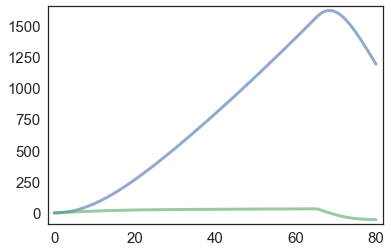

In [108]:
testCondition1 = condition
testCondition1.duration = 80
testCondition1.burnRate = 0.00107
system = make_system(testCondition1)
run_odeint(system,slope_func1)
print(system.results.m_engine)

plot(system.results.y)
plot(system.results.vy)

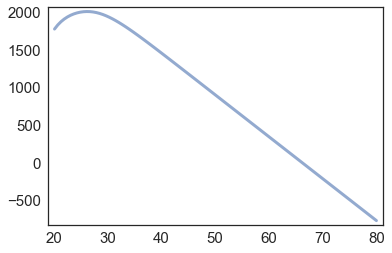

In [49]:
testCondition2 = condition2
testCondition2.duration = 80

system2 = make_system2(condition2, system.results.index[-1])

system2.init.y = system.results.y.iloc[-1]
system2.init.vy = system.results.vy.iloc[-1]
system2.init.m_engine = 0

run_odeint(system2,slope_func2)

plot(system2.results.y)
#plot(system2.results.vy)

In [13]:
#Takes everything above and rolls it together

"""
make this better
"""

def run_simulation(condition1, condition2, burn_rate, t_end=150, guess=80):
    
    #Runs the burn simulation initially
    condition1.set(duration=guess)
    
    condition1.set(burnRate=burn_rate)
    
    system=make_system(condition1)
    
    run_odeint(system,slope_func1)
    
    
    #Looks for the last time m_engine is positive
    results1 = parse_data(system.results)
    t_burnout = results1.index[-1]
    
    
    #Interpolates Results
    #Time = interp_inverse(system.results.m_engine)
    #t_burnout = Time(0)
    #print(t_burnout)
    #t_series_burnout = find_nearest(system.results.index, t_burnout)
    #results1 = system.results[:t_series_burnout]
    
    
    #Runs second simulation
    
    system2 = make_system2(condition2, t_burnout)

    system2.init.y = results1.y.iloc[-1]
    system2.init.vy = results1.vy.iloc[-1]
    system2.init.m_engine = 0
    
    
    condition2.set(duration=t_end)
    
    run_odeint(system2, slope_func2)
    
    results2 = system2.results
    
    
    
    #Combines results
    
    results = [results1, results2]
    
    combined = pd.concat(results)
    #print(combined.y.max())
    return combined.y
    #return combined.y.max()

In [ ]:
0.101007    1399.474050
0.101342    1398.267574

In [14]:
stuff = run_simulation(condition, condition2, 0.0018888888888)
plot(stuff)
label_axes(xlabel='Time (s)', ylabel='Height (m)', title='Trajectory of Best Burnrate')

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [9]:
def sweep_burns(sweep_array):
    sweep = SweepSeries()
    for rate in burn_array:
        sweep[rate] = run_simulation(condition, condition2, rate)
    return sweep

In [10]:
burn_array = linspace(0.001, 0.005, 100)
please = sweep_burns(burn_array)
please.index = please.index * 100

#print(please)
plot(please)
label_axes(xlabel='Burn Rate (cm/s)', ylabel='Max Height (m)', title='Maximum Height using Various Burn Rates')

best = please.max()
print("Best Height was", best, "meters with a burn rate of", please.idxmax(), "cm/s")

C:\ProgramData\Miniconda3\lib\site-packages\scipy\integrate\odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Best Height was 2229.72622233 meters with a burn rate of 0.188888888889 cm/s


In [134]:
# Set initial conditions NOTE: FOR ESTES ENGINE TO DETERMINE DRAG.  These conditions will be used in make_system to generate a system.

condition = Condition(# Set cap for simulation time
                      duration=105, #*s,
                      
                      # -----------------------------------------
                      # Initial state and environmental properties
                      # -----------------------------------------
                      y=0, #*m, 
                      g=9.8, #*m/s**2,
                      velocity=0, #*m/s,
                      rho_air=1.2, #*kg/m**3,
                      
                      # -----------------------------------------
                      # Properties of the rocket body
                      # -----------------------------------------
                      m_rocket=40, #*gm,
                      diameter=2.5, #*cm, 
                      C_d=0.75, 
                      thetaCone=85,
                      
                      # -----------------------------------------
                      # Properties of the engine and exhaust
                      # -----------------------------------------
                      m_engine=10.8, #*gm,
                      v_exhaust=5000, # * m/s,
                      rho_fuel=1.7, #*gm/cm**3,
                      engineSA=5.76, #*cm**2,
                      burnRate=0.4, #*cm/s,   THIS USED TO READ 1 (mm) which I think was wrong
                      
                      )

# Set initial conditions.  These conditions will be used in make_system to generate a system.

condition2 = Condition(# Set cap for simulation time
                      duration=105, #*s,
                      
                      # -----------------------------------------
                      # Initial state and environmental properties
                      # -----------------------------------------
                      y=0, #*m, 
                      g=9.8, #*m/s**2,
                      velocity=0, #*m/s,
                      rho_air=1.2, #*kg/m**3,
                      
                      # -----------------------------------------
                      # Properties of the rocket body
                      # -----------------------------------------
                      m_rocket=40, #*gm,
                      diameter=2.5, #*cm, 
                      C_d=0.75, 
                      thetaCone=85,
                      
                      # -----------------------------------------
                      # Properties of the engine and exhaust
                      # -----------------------------------------
                      m_engine=0, #*gm,
                      v_exhaust=5000, # * m/s,
                      rho_fuel=1.6426, #*gm/cm**3,
                      engineSA=4.5234, #*cm**2,
                      burnRate=0.1, #*cm/s,   THIS USED TO READ 1 (mm) which I think was wrong
                      
                      )